In [1]:
import numpy as np
from pylab import *
from craco.cardcap import CardcapFile
from astropy.io import fits
from craft.craftcor import MiriadGainSolutions
import glob
from craco.search_pipeline import location2pix, get_grid_lut_from_plan, grid_candidates,wait_for_starts,waitall,print_candidates
from craco.search_pipeline import NBINARY_POINT_FDMTIN 
import craco
import craco.search_pipeline
from craco.pyxrtutil import *
import craft.craco_plan

from craft import uvfits

from craft.craco_plan import PipelinePlan
from craft.craco import printstats,bl2ant
import logging
import time
import scipy

%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
cd /data/craco/ban115/craco-python/notebooks/data/SB43128/run3

/data/craco/ban115/craco-python/notebooks/data/SB43128/run3


In [3]:
fits='SB43128_run3.uvfits'
#its='/data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm00/frb_d0_t0_a1_sninf_lm00.fits'

xclbin='/data/craco/ban115/builds/binary_container_fe3fef0d.xclbin'
alloc_device_only=True

In [4]:
f = uvfits.open(fits)
plan = PipelinePlan(f, "--ndm 511 --flag-ants 23 --target-input-rms 16")

parsing values --ndm 511 --flag-ants 23 --target-input-rms 16


/data/craco/ban115/craft-github/src/craft/craco_plan.py:138: UserWarning: Cannot grid things on U=0 or V=0 blid=259.0 1-3 uvpix=(0, 254)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/data/craco/ban115/craft-github/src/craft/craco_plan.py:138: UserWarning: Cannot grid things on U=0 or V=0 blid=260.0 1-4 uvpix=(2, 0)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/data/craco/ban115/craft-github/src/craft/craco_plan.py:138: UserWarning: Cannot grid things on U=0 or V=0 blid=522.0 2-10 uvpix=(15, 0)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/data/craco/ban115/craft-github/src/craft/craco_plan.py:138: UserWarning: Cannot grid things on U=0 or V=0 blid=522.0 2-10 uvpix=(16, 0)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/data/craco/ban115/craft-github/src/craft/craco_plan.py:138: UserWarning: Cannot grid things on U=

Upper registers [(2, 1), (3, 1), (14, 1), (15, 1), (166, 1), (167, 1), (168, 1), (169, 1), (170, 1), (236, 1), (237, 1), (241, 1), (243, 1), (248, 1), (249, 1), (255, 1), (33, 2), (34, 2), (35, 2), (46, 2), (51, 2), (52, 2), (53, 2), (54, 2), (206, 2), (207, 2), (208, 2), (209, 2), (224, 2), (225, 2), (226, 2), (235, 2)]
Lower registers [(1, 2), (2, 3), (2, 4), (1, 5), (4, 5), (4, 7), (5, 8), (6, 8), (5, 9), (7, 9), (8, 9), (4, 10), (6, 10), (8, 10), (1, 11), (5, 11), (6, 11), (8, 11), (9, 11), (1, 12), (5, 12), (7, 12), (7, 13), (12, 14), (13, 14), (12, 15), (13, 15), (7, 16), (14, 16), (15, 16), (7, 17), (15, 17)]


In [5]:
values = craco.search_pipeline.get_parser().parse_args([])
plan.values.subtract = False

In [6]:
from craco import calibration
g = calibration.load_gains('run3.mir')
#g = np.ma.masked_where(g,np.abs(g) >0 )
g.shape



Using MIRIAD bandpass solutions


/data/craco/ban115/craft-github/src/craft/craftcor.py:643: RuntimeWarning: divide by zero encountered in true_divide
  g = 1/np.conj(g)
/data/craco/ban115/craft-github/src/craft/craftcor.py:643: RuntimeWarning: invalid value encountered in true_divide
  g = 1/np.conj(g)


(36, 288, 2)

In [7]:
# apply flags
g.mask[:,70:130,:] = True
g.mask[:,210:,:] = True
soln = calibration.gains2solarray(plan,g)

<IPython.core.display.Javascript object>


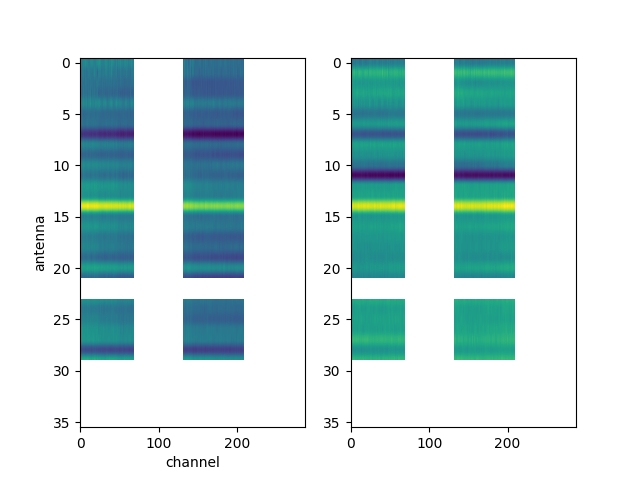

/data/craco/ban115/craco-python/venv/lib/python3.6/site-packages/numpy/ma/core.py:468: ComplexWarning: Casting complex values to real discards the imaginary part
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


In [8]:
fig, ax = subplots(1,2)

ax[0].imshow(abs(g[...,0]), aspect='auto')
ax[0].set_xlabel('channel')
ax[0].set_ylabel('antenna')
ax[1].imshow(abs(g[...,1]), aspect='auto')

In [9]:
device = pyxrt.device(0)
xbin = pyxrt.xclbin(xclbin)
uuid = device.load_xclbin(xbin)
p = craco.search_pipeline.Pipeline(device, xbin, plan, alloc_device_only)

Kernel krnl_ddgrid_reader_4cu:krnl_ddgrid_reader_4cu_1 has groups
GID=0=32
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=15
Kernel krnl_grid_4cu:krnl_grid_4cu_1 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=6
Kernel krnl_grid_4cu:krnl_grid_4cu_2 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=7
Kernel krnl_grid_4cu:krnl_grid_4cu_3 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=20
Kernel krnl_grid_4cu:krnl_grid_4cu_4 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=21
Kernel fft2d:fft2d_1 has groups
Kernel fft2d:fft2d_2 has groups
Kernel fft2d:fft2d_3 has groups
Kernel fft2d:fft2d_4 has groups
Kernel krnl_boxc_4cu:krnl_boxc_4cu_1 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=54
GID=4=54
GID=5=4
Kernel fdmt_tunable_c32:fdmt_tunable_c32_1 has groups
GID=0=52
GID=1=32
GID=2=53
GID=3=53
GID=4=14
Allocated 360428 bytes flags=flags.normal groupid=6 address=0x60000000
Allocated 360428 bytes flags=flags.normal groupid=7 address=0x70000000
Allo

In [10]:
vis_source = craco.search_pipeline.VisSource(plan, f, values)

In [11]:
for ibl, input_flat in enumerate(vis_source):
    print(input_flat.shape)
    break

(406, 288, 2, 256)


<IPython.core.display.Javascript object>


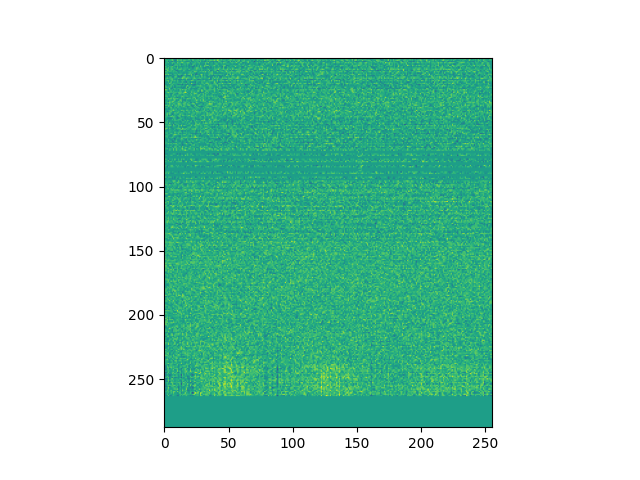

In [12]:
figure()
imshow(input_flat.real[0,:,0,:])

In [13]:
plan.values.subtract = True
p.plan.values.target_input_rms=32
p.set_calibration_gains(g)
input_flat_cal = p.calibrate_input(input_flat.copy())

def interp_model(input_flat, navg=6):    
    # average over time
    print(input_flat.shape)
    model = input_flat.mean(axis=-1)
    print(model.shape)
    # squish pols in to 
    chan_avg_model = model.reshape(model.shape[0], -1, navg).mean(axis=-1)
    chans = np.arange(chan_avg_model.shape[1])
    print(chan_avg_model.shape)
    print(chans)
    interp = scipy.interpolate.interp1d(chans, chan_avg_model, kind='linear', axis=-1, bounds_error=False, fill_value='extrapolate')
    upchans = np.arange(model.shape[1])/navg - 0.5
    print(upchans)
    interp_out = interp(upchans)
    
    return interp_out
    

def my_calibrate_input(input_flat):
    input_flat *= p.solarray
    # subtract model
    model = input_flat.mean(axis=-1)
    model = interp_model(model)        
    
    input_flat -= model
    
    # sum pols
    input_flat = input_flat.mean(axis=2)        
    
    return input_flat

#input_flat_cal = my_calibrate_input(input_flat.copy())


<IPython.core.display.Javascript object>


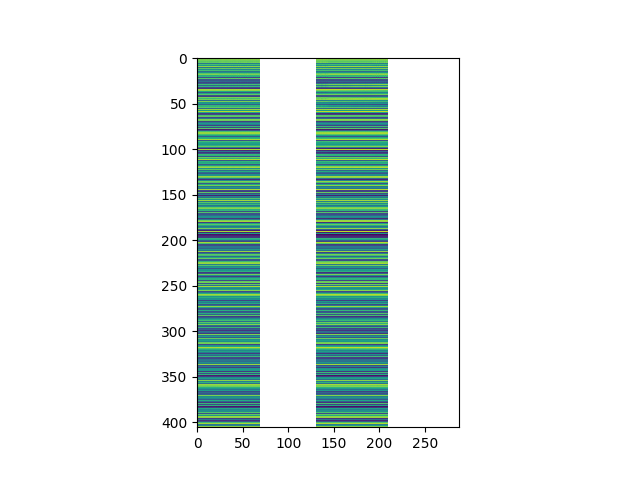

In [14]:
p.solarray.shape
figure()
imshow(p.solarray[:,:,0,0].real)

<IPython.core.display.Javascript object>


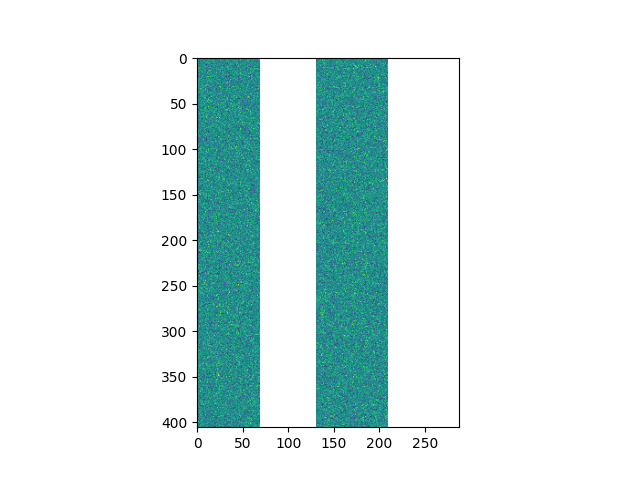

In [16]:
input_flat_cal.shape
figure()
imshow(input_flat_cal.mean(axis=-1).real)

In [72]:
input_flat_cal.shape

(406, 288, 256)

<IPython.core.display.Javascript object>


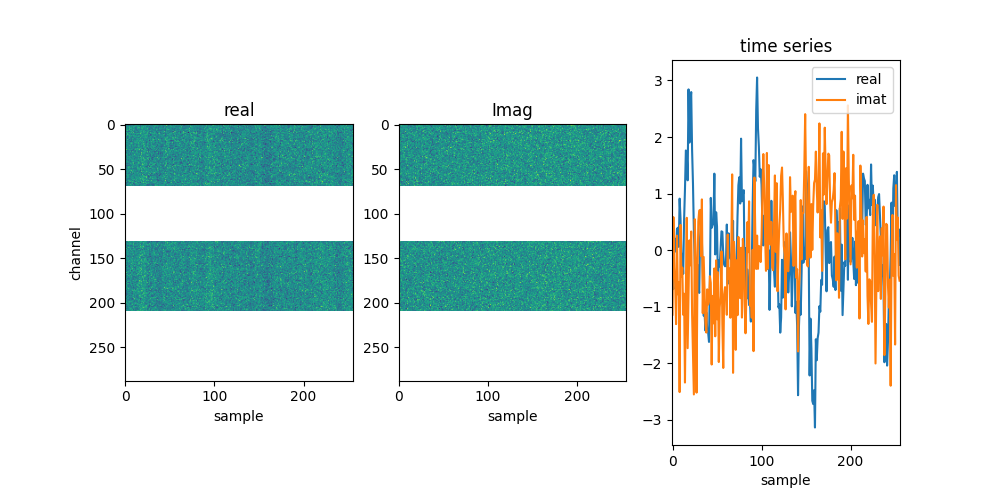

In [89]:
fig,ax = subplots(1,3,sharex=True)
fig.set_size_inches((10,5))
phasecenter = input_flat_cal.mean(axis=0)
phasecenter_t = phasecenter.mean(axis=0)
ax[0].imshow(phasecenter.real)
ax[1].imshow(phasecenter.imag)
ax[2].plot(phasecenter_t.real/phasecenter_t.real.std(), label='real')
ax[2].plot(phasecenter_t.imag/phasecenter_t.imag.std(), label='imat')
ax[0].set_title('real')
ax[1].set_title('Imag')
ax[2].set_title('time series')
ax[0].set_xlabel('sample')
ax[1].set_xlabel('sample')
ax[2].set_xlabel('sample')
ax[0].set_ylabel('channel')
ax[2].legend()


In [17]:
input_flat_bp = input_flat * soln
input_flat_bp.shape

(406, 288, 2, 256)

In [18]:
soln.shape

(406, 288, 2, 1)

<IPython.core.display.Javascript object>


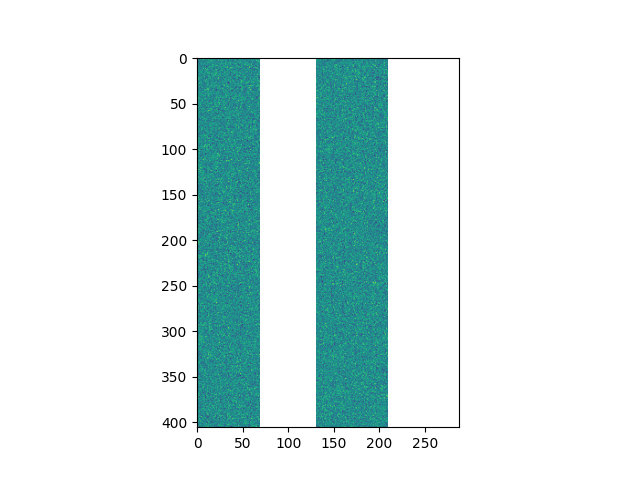

In [19]:
figure()
#imshow(soln.mask[0,:,0,0])
imshow(input_flat_bp[:,:,0,0].real)

<IPython.core.display.Javascript object>


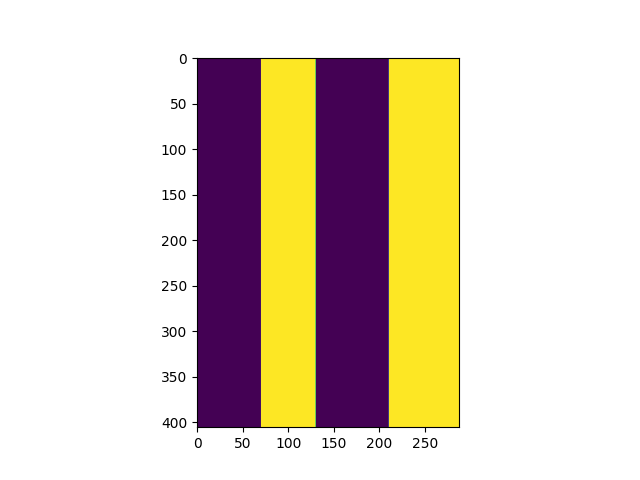

In [20]:
input_flat_bp.mask.shape
figure()
imshow(soln.mask[:,:,0,0].astype(int))

<IPython.core.display.Javascript object>


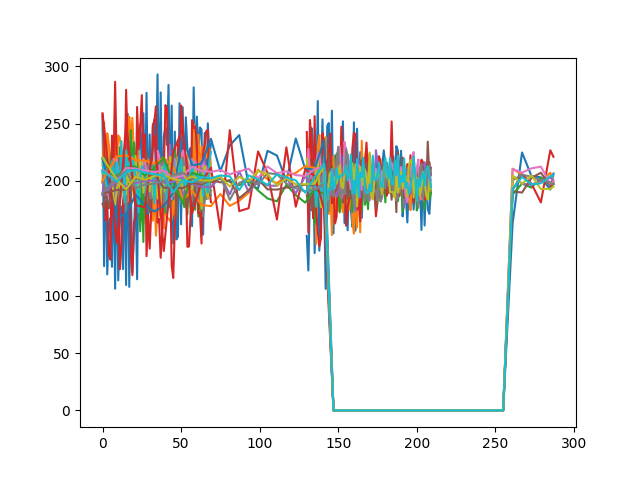

(406, 288, 2, 256)
(406, 288, 2)
(406, 96)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
[-0.5        -0.33333333 -0.16666667  0.          0.16666667  0.33333333
  0.5         0.66666667  0.83333333  1.          1.16666667  1.33333333
  1.5         1.66666667  1.83333333  2.          2.16666667  2.33333333
  2.5         2.66666667  2.83333333  3.          3.16666667  3.33333333
  3.5         3.66666667  3.83333333  4.          4.16666667  4.33333333
  4.5         4.66666667  4.83333333  5.          5.16666667  5.33333333
  5.5         5.66666667  5.83333333  6.          6.16666667  6.33333333
  6.5         6.66666667  6.83333333  7.          7.16666667  7.33333333
  7.5         7.66666667  7.83333333  8.          8.16666667  8.33333333
  8.5  

In [88]:
figure()

mdl = interp_model(input_flat_bp.real)
flatavg = input_flat_bp.mean(axis=-1)
                   
plot(np.real(flatavg[:10,:,0]).T);
plot(mdl[:10,:].T);

In [22]:
input_flat_cal.shape

(406, 288, 256)

In [23]:
input_flat_cal.mean()

(-7.177958101894274e-09+3.3827728376028487e-10j)

In [24]:
input_flat_cal.real.std()

31.998882700748727

<IPython.core.display.Javascript object>


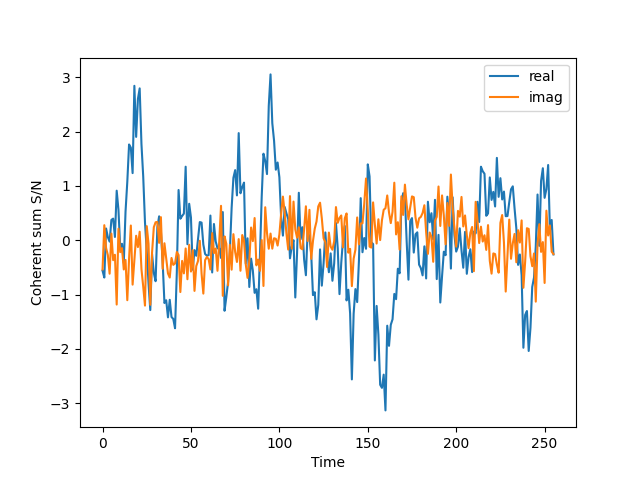

Text(0, 0.5, 'Coherent sum S/N')

In [71]:
figure()
meantime = input_flat_cal.mean(axis=0).mean(axis=0)
plot(meantime.real/meantime.real.std(), label='real')
plot(meantime.imag/meantime.real.std(), label='imag')
xlabel('Time')
legend()
ylabel('Coherent sum S/N')

In [26]:
input_flat_cal.real.mean()

-7.177958102820485e-09

In [27]:
input_flat_cal.real.std()

31.998882700748727

<IPython.core.display.Javascript object>


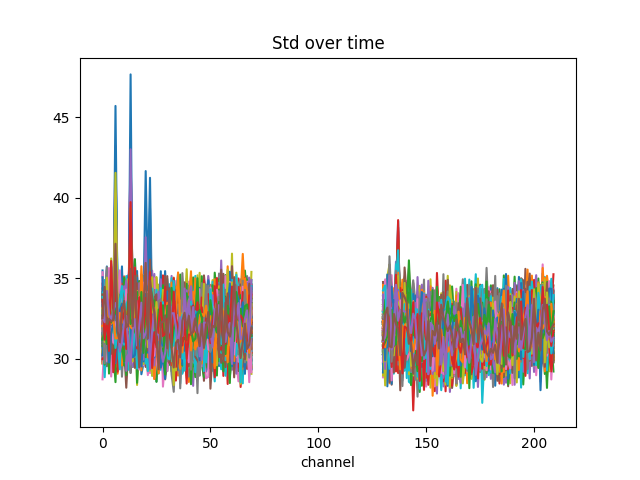

Text(0.5, 1.0, 'Std over time')

In [28]:
figure()
plot(input_flat_cal.real.std(axis=0));
xlabel('channel')
title('Std over time')

<IPython.core.display.Javascript object>


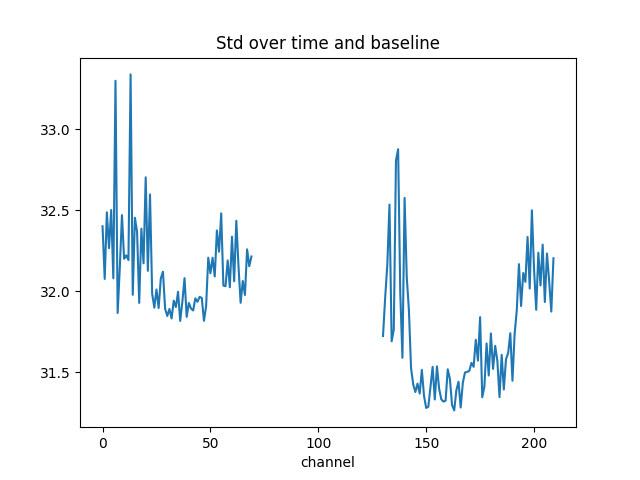

Text(0.5, 1.0, 'Std over time and baseline')

In [29]:
figure()
plot(input_flat_cal.real.std(axis=0).mean(axis=1));
xlabel('channel')
title('Std over time and baseline')

<IPython.core.display.Javascript object>


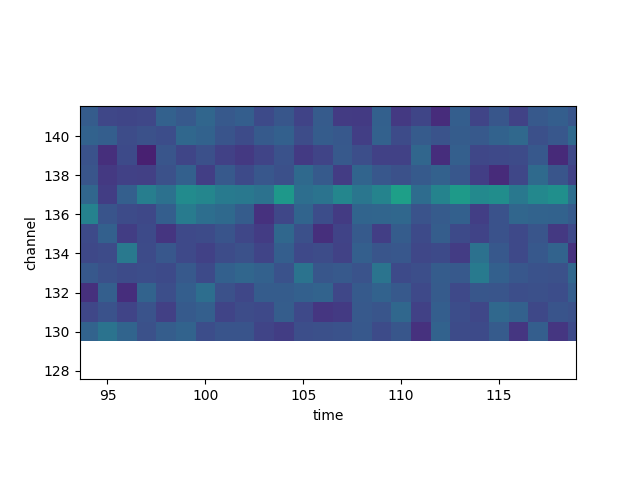

Text(0, 0.5, 'channel')

In [30]:
rfimask = input_flat_cal.real.std(axis=0)
figure()
imshow(rfimask, origin='lower')
xlabel('time')
ylabel('channel')

<IPython.core.display.Javascript object>


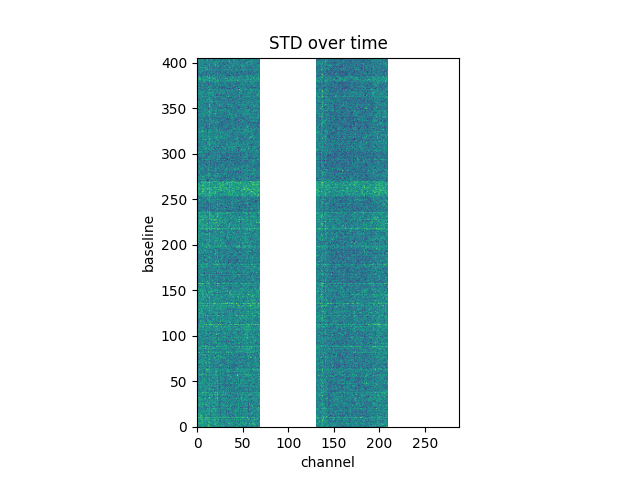

Text(0.5, 1.0, 'STD over time')

In [31]:
rfimask = input_flat_cal.real.std(axis=2)
figure()
imshow(rfimask, origin='lower')
xlabel('channel')
ylabel('baseline')
title('STD over time')

In [32]:
#input_flat[220:,:,:] = 0
#input_flat[73:96,:,:] = 0

In [33]:
np.std(input_flat_cal.imag)

32.00111726024143

In [34]:
nosieamp = []
nsum = p.plan.nbl*p.plan.nf
values.input_scale = 1
values.threshold = 1
#p.solarray.mask[:,70:95,:] = True
#p.solarray.mask[:,238:,:] = True
p.copy_input(input_flat.copy(), values)
p.run(0,values).wait()
c = p.get_candidates()
len(c)

8192

In [35]:
p.last_bc_noise_level

1.9279629186332916

In [36]:
expected_image_noise_level = p.last_bc_noise_level*4 # bc scales image by 4x for some reason
expected_image_noise_level

7.7118516745331664

In [37]:
last_threshold = p.last_bc_noise_level*values.threshold
last_threshold

1.9279629186332916

In [38]:
c.dtype

dtype([('snr', '<i2'), ('loc_2dfft', '<u2'), ('boxc_width', 'u1'), ('time', 'u1'), ('dm', '<u2')])

<IPython.core.display.Javascript object>


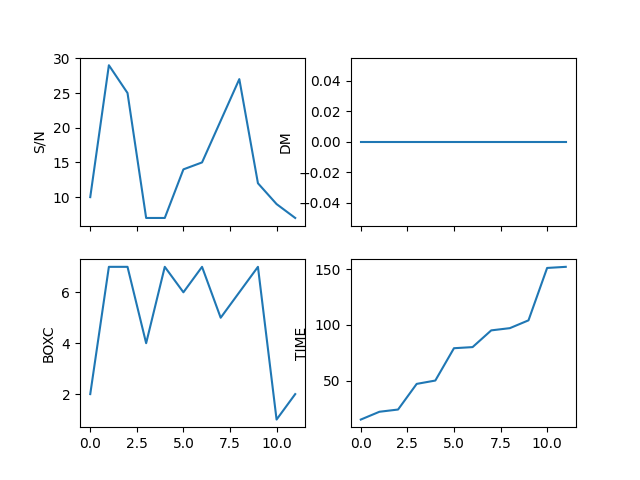

15.25 7.843521743026747


Text(0, 0.5, 'TIME')

In [39]:
fig,ax = subplots(2,2,sharex=True)
mask = (c['dm'] == 0) & (c['loc_2dfft'] == 0)
c = c[mask]
sn = c['snr'] #[c['dm'] == 0]
ax[0,0].plot(sn)
ax[0,0].set_ylabel('S/N')

print(sn.mean(), sn.std())
ax[0,1].plot(c['dm'])
ax[0,1].set_ylabel('DM')
ax[1,0].plot(c['boxc_width'])
ax[1,0].set_ylabel('BOXC')
ax[1,1].plot(c['time'])
ax[1,1].set_ylabel('TIME')

In [40]:
mask = (c['dm'] == 0) & (c['loc_2dfft'] == 0)
c[mask]

array([(10, 0, 2,  15, 0), (29, 0, 7,  22, 0), (25, 0, 7,  24, 0),
       ( 7, 0, 4,  47, 0), ( 7, 0, 7,  50, 0), (14, 0, 6,  79, 0),
       (15, 0, 7,  80, 0), (21, 0, 5,  95, 0), (27, 0, 6,  97, 0),
       (12, 0, 7, 104, 0), ( 9, 0, 1, 151, 0), ( 7, 0, 2, 152, 0)],
      dtype=[('snr', '<i2'), ('loc_2dfft', '<u2'), ('boxc_width', 'u1'), ('time', 'u1'), ('dm', '<u2')])

In [41]:
inbuf = p.inbuf.copy_from_device().nparr
inbuf.shape

(579, 256, 32, 8, 2)

In [42]:
inbuf[...,0].mean()

4.076916524989205e-05

In [43]:
(inbuf != 0).sum()/256/2


58770.494140625

In [44]:
inbuf[...,0].std()

20.271056751802444

In [45]:
bc = p.boxcar_history.copy_from_device().nparr
bc.shape

(1024, 7, 256, 256)

<IPython.core.display.Javascript object>


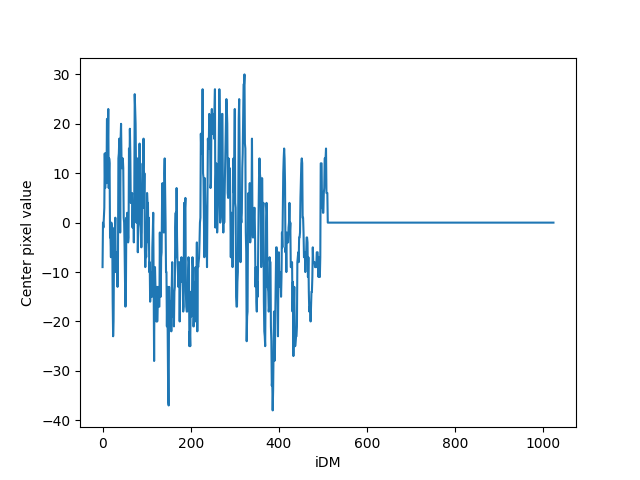

Text(0, 0.5, 'Center pixel value')

In [46]:
figure()
plot(bc[:,0,0,0])
xlabel('iDM')
ylabel('Center pixel value')

<IPython.core.display.Javascript object>


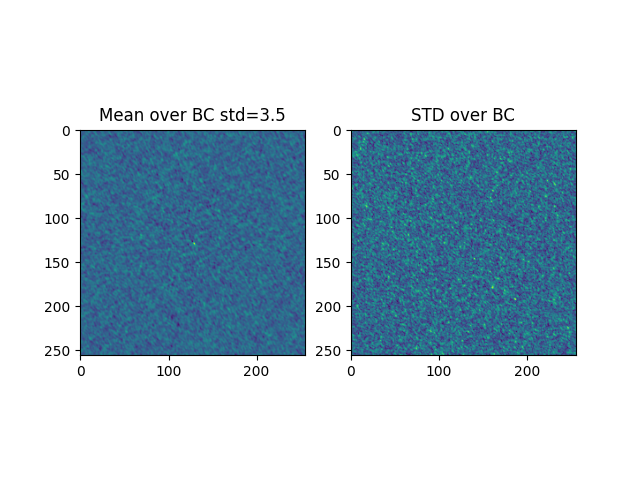

Text(0.5, 1.0, 'Mean over BC std=3.5')

In [47]:
bc0 = np.fft.fftshift(bc[0,...])
fig,ax = subplots(1,2)
ax[1].imshow(bc0.std(axis=0))
ax[1].set_title('STD over BC')
ax[0].imshow(bc0.mean(axis=0))
ax[0].set_title(f'Mean over BC std={bc0.mean(axis=0).std():0.1f}')


<IPython.core.display.Javascript object>


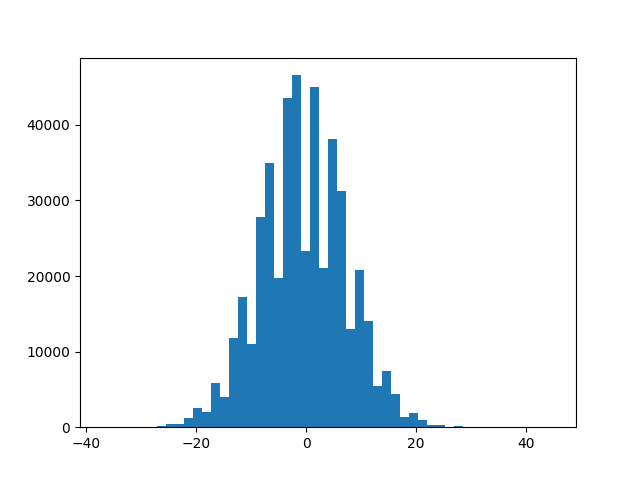

7.834214241866054


In [48]:
figure()
hist(bc0.flat, bins=50)
print(bc0.std())

<IPython.core.display.Javascript object>


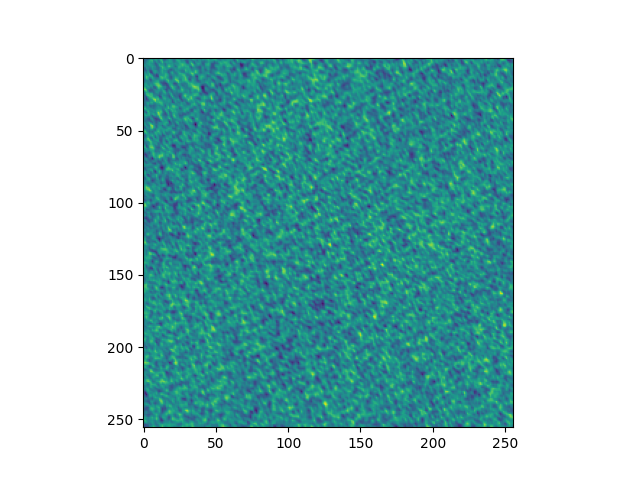

' max/min/mean/rms/sum/S/N = 3.50e+01/-3.30e+01/-5.01e-01/7.78e+00/-3.28e+04/4.5 peak at (143, 165)'

In [49]:
fig = figure()
img = bc0[4,:,:]
imshow(img)
printstats(img)

<IPython.core.display.Javascript object>


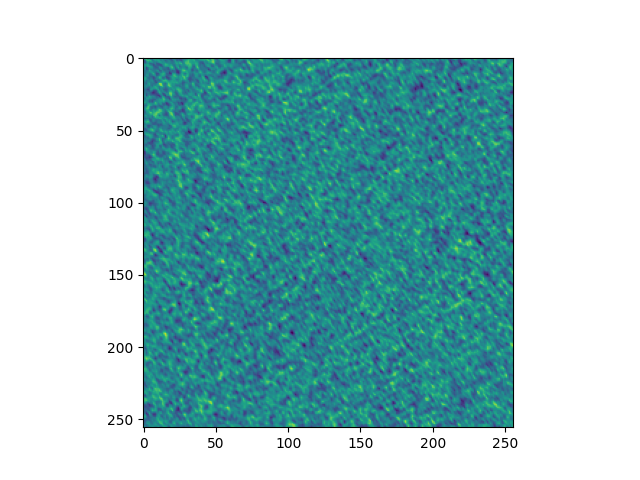

In [50]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
fig = figure()
img = np.fft.fftshift(bc0-bc0.mean(axis=0, keepdims=True))
ax = imshow(img[0,:,:])
def animate(frame_num):
    nbc = img.shape[0]
    ax.set_data(img[frame_num % nbc])
    
    return ax

anim = FuncAnimation(fig, animate, frames=10, interval=50, repeat=False)
anim.save('bc_animation.gif', writer='pillow', fps=15)
#plt.show()

In [51]:
input_flat_cal.mask[:,70:95,:] = True
input_flat_cal.mask[:,238:,:] = True


In [52]:
input_flat_cal.shape

(406, 288, 256)

In [53]:
sn = input_flat_cal.real.mean(axis=2).real/input_flat_cal.real.std(axis=2)

<IPython.core.display.Javascript object>


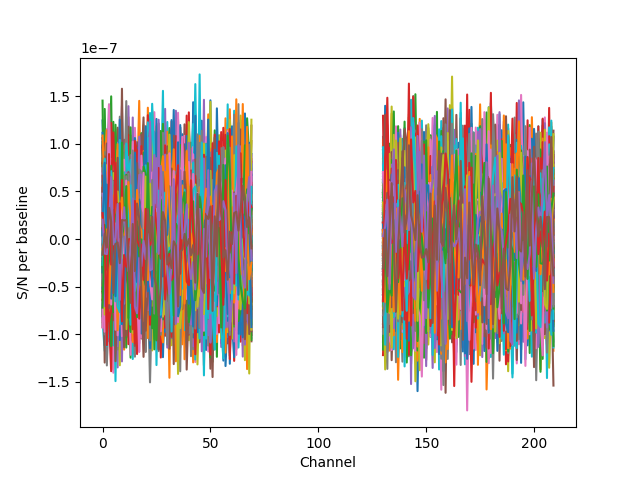

Text(0.5, 0, 'Channel')

In [54]:
figure()
plot(sn.T);
ylabel('S/N per baseline')
xlabel('Channel')

/data/craco/ban115/craco-python/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


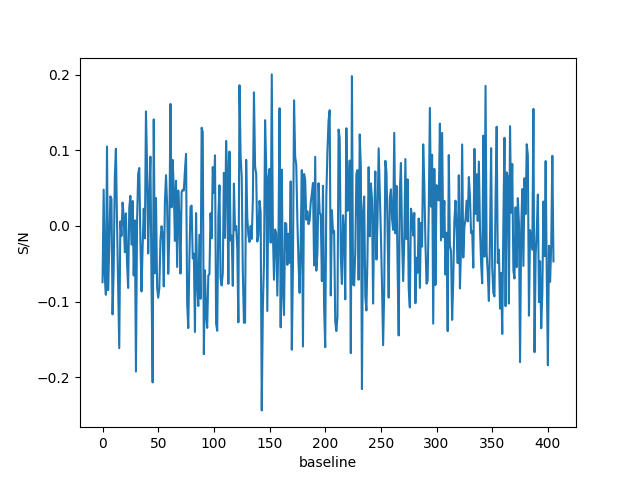

Text(0, 0.5, 'S/N')

In [55]:
figure()
snbl = sn.mean(axis=1)/sn.std(axis=1)
plot(snbl)
xlabel('baseline')
ylabel('S/N')

In [56]:
input_flat_cal.shape

(406, 288, 256)

<IPython.core.display.Javascript object>


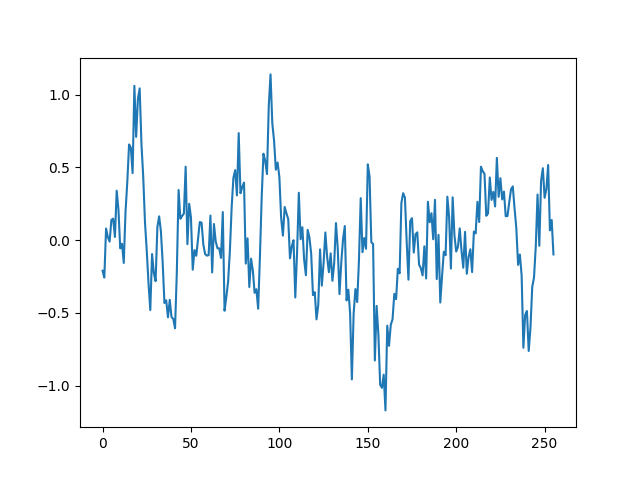

In [57]:
figure()
plot(input_flat_cal.mean(axis=0).mean(axis=0).real)

In [58]:
c = p.get_candidates()
len(c)

8192

In [59]:
c[0]

(5, 12, 2, 2, 0)

# Look at numpy history files

In [60]:
!ls -lh *.npy

-rw-rw-r-- 1 ban115 ban115 897M Sep  6 17:26 boxcar_hist_iblk0.npy
-rw-rw-r-- 1 ban115 ban115 897M Sep  6 17:26 boxcar_hist_iblk1.npy
-rw-rw-r-- 1 ban115 ban115 897M Sep  6 17:26 boxcar_hist_iblk2.npy
-rw-rw-r-- 1 ban115 ban115 897M Sep  6 17:27 boxcar_hist_iblk3.npy
-rw-rw-r-- 1 ban115 ban115 897M Sep  6 17:27 boxcar_hist_iblk4.npy
-rw-rw-r-- 1 ban115 ban115 897M Sep  6 17:28 boxcar_hist_iblk5.npy
-rw-rw-r-- 1 ban115 ban115 897M Sep  6 17:28 boxcar_hist_iblk6.npy
-rw-rw-r-- 1 ban115 ban115 897M Sep  6 17:29 boxcar_hist_iblk7.npy
-rw-rw-r-- 1 ban115 ban115 897M Sep  6 17:29 boxcar_hist_iblk8.npy
-rw-rw-r-- 1 ban115 ban115 897M Sep  6 17:30 boxcar_hist_iblk9.npy
-rw-rw-r-- 1 ban115 ban115 145M Sep  6 17:25 uv_data_iblk0.npy
-rw-rw-r-- 1 ban115 ban115 145M Sep  6 17:26 uv_data_iblk1.npy
-rw-rw-r-- 1 ban115 ban115 145M Sep  6 17:26 uv_data_iblk2.npy
-rw-rw-r-- 1 ban115 ban115 145M Sep  6 17:27 uv_data_iblk3.npy
-rw-rw-r-- 1 ban115 ban115 145M Sep  6 17:27 uv_data_iblk4.npy
-rw-rw-r-- 1 ba

In [61]:
inbuf = np.load('uv_data_iblk0.npy')
inbuf.shape

(579, 256, 32, 8, 2)

In [62]:
inbufrs = np.transpose(inbuf, [0,3,1,2,4]).reshape((-1,256,32,2))
inbufrs.shape

(4632, 256, 32, 2)

<IPython.core.display.Javascript object>


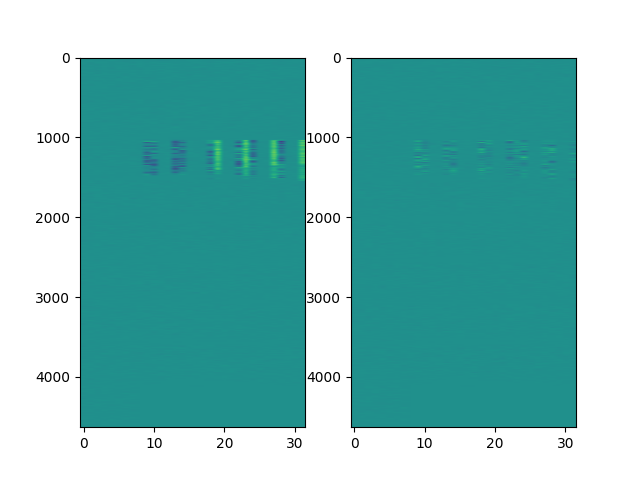

In [63]:
fig, ax = subplots(1,2)
ax[0].imshow(inbufrs[:,:,:,0].mean(axis=1), aspect='auto')
ax[1].imshow(inbufrs[:,:,:,1].mean(axis=1), aspect='auto')

In [64]:
inbuf.shape

(579, 256, 32, 8, 2)

<IPython.core.display.Javascript object>


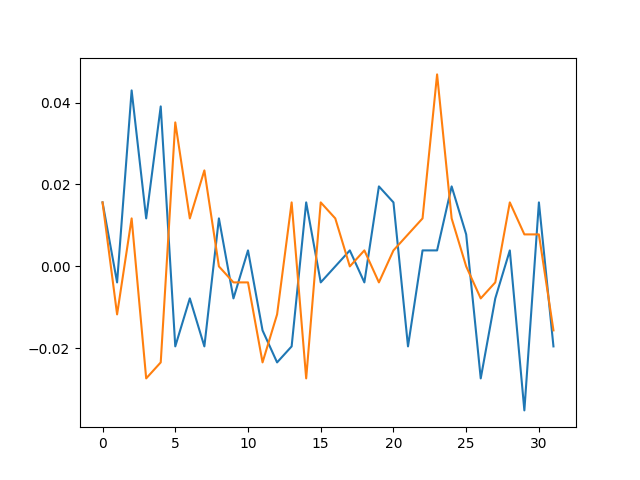

In [65]:
figure()
plot(inbuf[0,:,:,0,:].mean(axis=0))

<IPython.core.display.Javascript object>


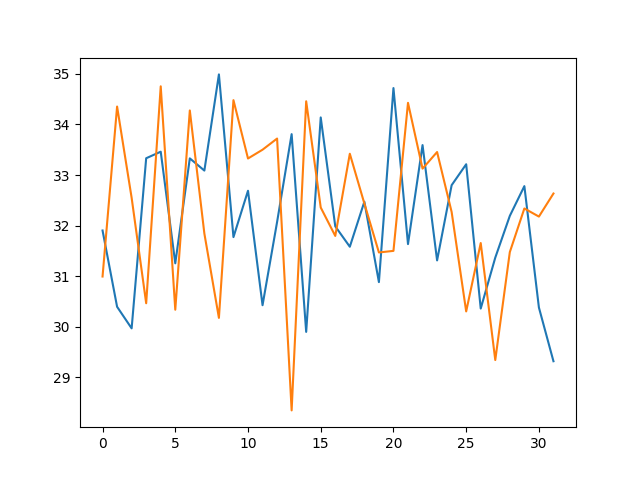

In [66]:
figure()
plot(inbuf[0,:,:,0,:].std(axis=0))

In [67]:
!ls -lh *.npy

-rw-rw-r-- 1 ban115 ban115 897M Sep  6 17:26 boxcar_hist_iblk0.npy
-rw-rw-r-- 1 ban115 ban115 897M Sep  6 17:26 boxcar_hist_iblk1.npy
-rw-rw-r-- 1 ban115 ban115 897M Sep  6 17:26 boxcar_hist_iblk2.npy
-rw-rw-r-- 1 ban115 ban115 897M Sep  6 17:27 boxcar_hist_iblk3.npy
-rw-rw-r-- 1 ban115 ban115 897M Sep  6 17:27 boxcar_hist_iblk4.npy
-rw-rw-r-- 1 ban115 ban115 897M Sep  6 17:28 boxcar_hist_iblk5.npy
-rw-rw-r-- 1 ban115 ban115 897M Sep  6 17:28 boxcar_hist_iblk6.npy
-rw-rw-r-- 1 ban115 ban115 897M Sep  6 17:29 boxcar_hist_iblk7.npy
-rw-rw-r-- 1 ban115 ban115 897M Sep  6 17:29 boxcar_hist_iblk8.npy
-rw-rw-r-- 1 ban115 ban115 897M Sep  6 17:30 boxcar_hist_iblk9.npy
-rw-rw-r-- 1 ban115 ban115 145M Sep  6 17:25 uv_data_iblk0.npy
-rw-rw-r-- 1 ban115 ban115 145M Sep  6 17:26 uv_data_iblk1.npy
-rw-rw-r-- 1 ban115 ban115 145M Sep  6 17:26 uv_data_iblk2.npy
-rw-rw-r-- 1 ban115 ban115 145M Sep  6 17:27 uv_data_iblk3.npy
-rw-rw-r-- 1 ban115 ban115 145M Sep  6 17:27 uv_data_iblk4.npy
-rw-rw-r-- 1 ba

In [46]:
!pwd


/data/craco/ban115/craco-python/notebooks/data/SB43128/run3


In [47]:
bc = np.load('boxcar_hist_iblk0.npy')
bc.shape

(1024, 7, 256, 256)

<IPython.core.display.Javascript object>


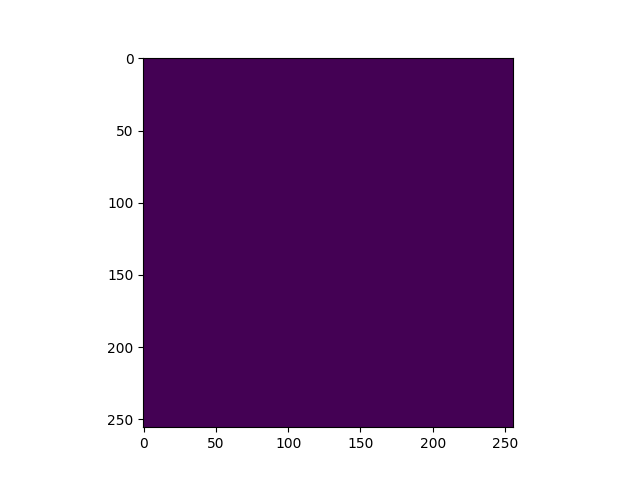

In [48]:
figure()
imshow(np.fft.fftshift(bc[0,:,:,:]).mean(axis=0))

# with simulation

In [113]:
!ls -lrth *.npy

-rw-rw-r-- 1 ban115 ban115 145M Sep  6 17:29 uv_data_iblk8.npy
-rw-rw-r-- 1 ban115 ban115 897M Sep  6 17:29 boxcar_hist_iblk8.npy
-rw-rw-r-- 1 ban115 ban115 145M Sep  6 17:29 uv_data_iblk9.npy
-rw-rw-r-- 1 ban115 ban115 897M Sep  6 17:30 boxcar_hist_iblk9.npy
-rw-rw-r-- 1 ban115 ban115 145M Sep  9 15:10 uv_data_iblk7.npy
-rw-rw-r-- 1 ban115 ban115 897M Sep  9 15:10 boxcar_hist_iblk7.npy
-rw-rw-r-- 1 ban115 ban115 145M Sep  9 15:14 uv_data_iblk0.npy
-rw-rw-r-- 1 ban115 ban115 897M Sep  9 15:14 boxcar_hist_iblk0.npy
-rw-rw-r-- 1 ban115 ban115 145M Sep  9 15:14 uv_data_iblk1.npy
-rw-rw-r-- 1 ban115 ban115 897M Sep  9 15:14 boxcar_hist_iblk1.npy
-rw-rw-r-- 1 ban115 ban115 145M Sep  9 15:14 uv_data_iblk2.npy
-rw-rw-r-- 1 ban115 ban115 897M Sep  9 15:14 boxcar_hist_iblk2.npy
-rw-rw-r-- 1 ban115 ban115 145M Sep  9 15:14 uv_data_iblk3.npy
-rw-rw-r-- 1 ban115 ban115 897M Sep  9 15:15 boxcar_hist_iblk3.npy
-rw-rw-r-- 1 ban115 ban115 145M Sep  9 15:15 uv_data_iblk4.npy
-rw-rw-r-- 1 ban115 ban115 

In [145]:
uvin = np.load('uv_data_iblk0.npy')
uvin.shape


(579, 256, 32, 8, 2)

In [146]:
np.all(uvin==0)

False

In [147]:
np.all(uvin[...,1] == 0)

False

In [148]:
uvin[uvin != 0].std()

129.0709837945948

<IPython.core.display.Javascript object>


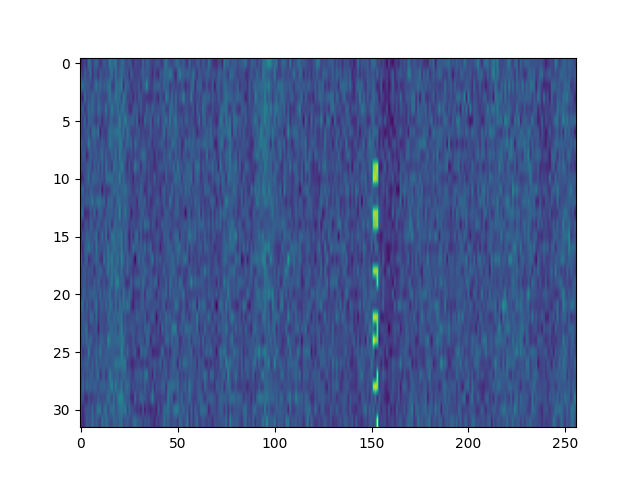

In [149]:
figure()
imshow(uvin[...,0].mean(axis=(0,3)).T, aspect='auto')

In [152]:
uvin.shape

(579, 256, 32, 8, 2)

<IPython.core.display.Javascript object>


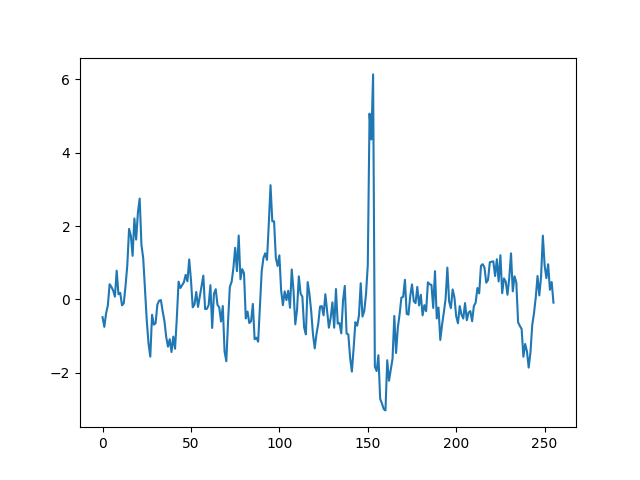

In [153]:
figure()
plot(uvin[...,0].mean(axis=(0,2,3)).T)

In [155]:
bc = np.load('boxcar_hist_iblk0.npy')
bc.shape

(1024, 7, 256, 256)

<IPython.core.display.Javascript object>


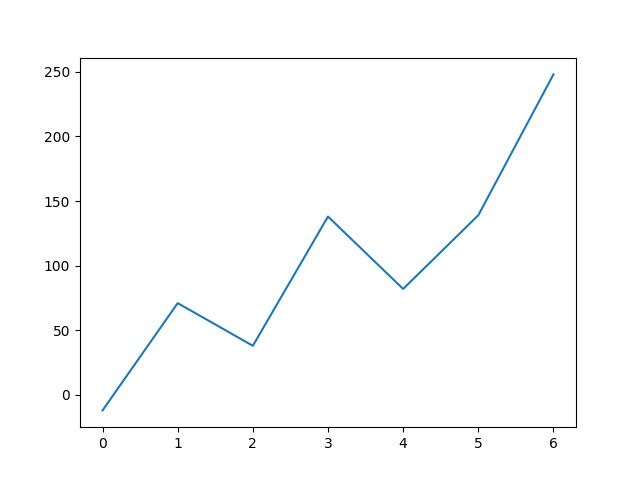

In [156]:
figure()
plot(bc[0,:,0,0])

In [159]:
bc[0].std()

45.95616326011775

<IPython.core.display.Javascript object>


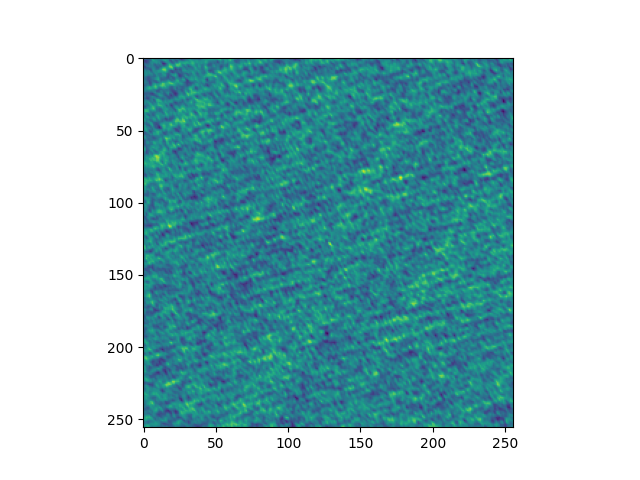

In [158]:
figure()
imshow(np.fft.fftshift(bc[0,3,...]))

In [160]:
print(printstats(bc[0,...]))

 max/min/mean/rms/sum/S/N = 3.00e+02/-2.22e+02/-5.00e-01/4.60e+01/-2.29e+05/6.5 peak at (6, 1, 1)


<IPython.core.display.Javascript object>


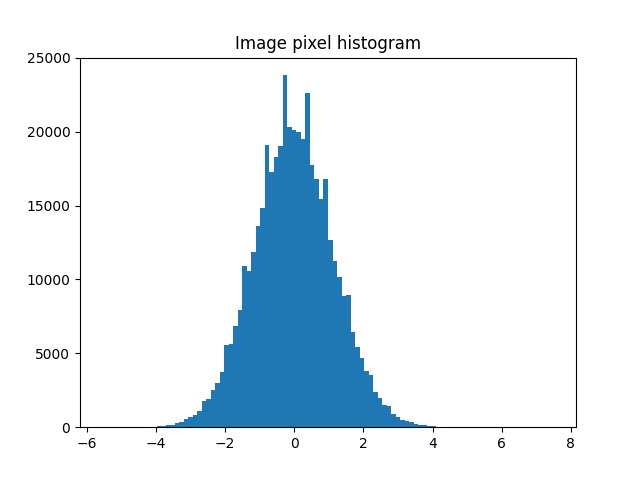

(array([1.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00, 4.0000e+00,
        3.0000e+00, 7.0000e+00, 7.0000e+00, 8.0000e+00, 2.1000e+01,
        2.9000e+01, 3.8000e+01, 5.3000e+01, 8.1000e+01, 1.5000e+02,
        1.7100e+02, 2.5800e+02, 3.6300e+02, 5.4600e+02, 6.5900e+02,
        8.4600e+02, 1.0920e+03, 1.7630e+03, 1.9070e+03, 2.4990e+03,
        2.9850e+03, 3.7570e+03, 5.5840e+03, 5.6590e+03, 6.8580e+03,
        7.9150e+03, 1.0915e+04, 1.0559e+04, 1.1891e+04, 1.3605e+04,
        1.4811e+04, 1.9089e+04, 1.7296e+04, 1.8286e+04, 1.9042e+04,
        2.3832e+04, 2.0300e+04, 2.0108e+04, 1.9958e+04, 1.9481e+04,
        2.2604e+04, 1.7772e+04, 1.6796e+04, 1.5437e+04, 1.6798e+04,
        1.2681e+04, 1.1286e+04, 1.0170e+04, 8.8610e+03, 8.9550e+03,
        6.4200e+03, 5.4210e+03, 4.6690e+03, 3.8070e+03, 3.5430e+03,
        2.3970e+03, 1.9860e+03, 1.5070e+03, 1.4060e+03, 9.1700e+02,
        6.7700e+02, 5.1100e+02, 4.4900e+02, 3.3800e+02, 2.4300e+02,
        1.7800e+02, 1.2100e+02, 1.0900e+02, 7.00

In [162]:
figure()
title('Image pixel histogram')
hist(bc[0,...].flatten()/40, bins=100)
#ylim(0,10)